In [221]:
import torch
import random
import numpy as np
from numpy.linalg import det
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import norm
from scipy.stats.distributions import chi2
from random import shuffle
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal

## Creating Dataset

In [29]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)


c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [30]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [31]:
n_dim = 2
n_classes = 2
n_datasets = 4
device = 'cpu'

In [32]:
mu = np.array([0, 0])
separation = 6
A = np.random.randn(2, 2)
cov = .1 * np.dot(A.T, A) + np.eye(2)
v = np.array([np.cos((np.pi / 180) * 45), np.sin((np.pi / 180) * 45)])
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt = torch.from_numpy(X).float()
Yt = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()

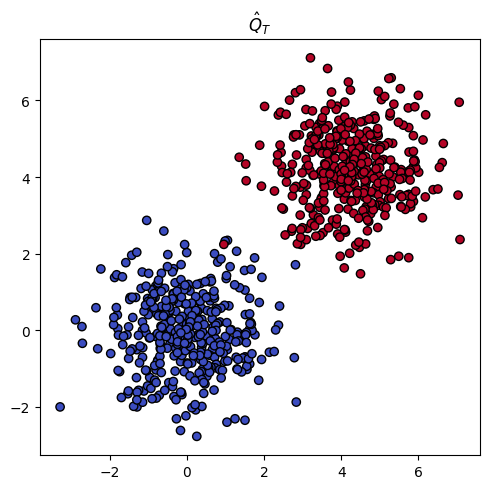

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=Xt[:, 0], y=Xt[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

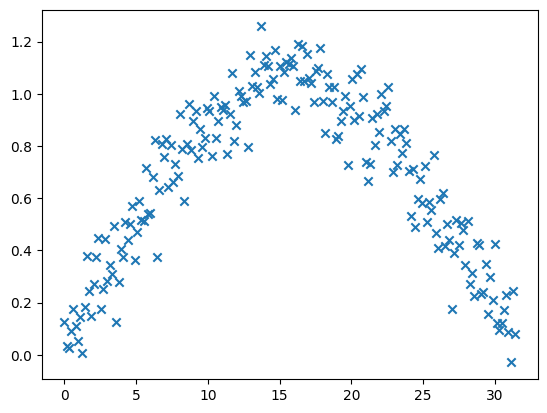

In [34]:
abs = np.linspace(0, 10*np.pi, 200)
np.random.seed(None)
def arc(x):
    return np.sin(x/10) + np.random.normal(0.05, 0.1, 200)

X_arc = np.concatenate((abs.reshape((200, 1)), arc(abs).reshape((200, 1))), axis=1)

fig, ax = plt.subplots(1, 1)
ax.scatter(X_arc[:, 0], X_arc[:, 1], marker = 'x')

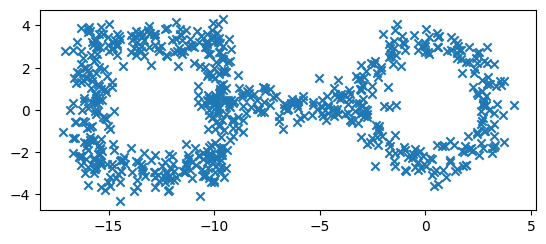

In [35]:
# Number of data points for each component
num_points = 200

# Generate data for a ring
radius = 3
theta_ring = np.linspace(0, 2 * np.pi, num_points)
ring_x = radius * np.cos(theta_ring)
ring_y = radius * np.sin(theta_ring)

# Define the side length of the square
side_length = 6

# Generate points for all sides of the square

# Generate points for the bottom side of the square
bottom_x = np.linspace(-10 - side_length, -10, num_points//2)
bottom_y = np.full(num_points//2, -side_length / 2)

# Generate points for the top side of the square
top_x = np.linspace(-10 - side_length, -10, num_points//2)  # Reversed order
top_y = np.full(num_points//2, side_length / 2)

# Generate points for the left side of the square
left_x = np.full(num_points//2, -10 - side_length)
left_y = np.linspace(-side_length / 2, side_length / 2, num_points//2)

# Generate points for the right side of the square
right_x = np.full(num_points//2, -10)
right_y = np.linspace(side_length / 2, -side_length / 2, num_points//2)  # Reversed order

# Combine all points to create the square dataset
square_x = np.concatenate((bottom_x, right_x, top_x, left_x))
square_y = np.concatenate((bottom_y, right_y, top_y, left_y))

# Generate data for a connecting line
line_x = np.linspace(-3, -10, num_points//2)
line_y = np.zeros(num_points//2)

# Combine the datasets
x = np.concatenate((ring_x, square_x, line_x))
y = np.concatenate((ring_y, square_y, line_y))

x += np.random.normal(0.2, 0.5, len(x))
y += np.random.normal(0.2, 0.5, len(y))

X_ring_and_square = np.concatenate((x.reshape((len(x), 1)), y.reshape((len(y), 1))), axis=1)

plt.scatter(x, y, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Python Implementation of Incremental Learning based on Growing Gaussian Mixture Models

Global variables

In [208]:
a = 0.8

Utility functions

In [219]:
matrix = np.array([[2, -1, 5],
                  [1, 3, -1],
                  [6, -3, -2]])

# Calculate the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(matrix)
delta_nu = np.sqrt(a*np.max(eigenvalues)) * eigenvectors[:, np.argmax(eigenvalues)]
np.dot(delta_nu.reshape((3, 1)), delta_nu.reshape((1, 3)))

array([[2.87876273, 0.27497998, 2.15214316],
       [0.27497998, 0.02626614, 0.20557314],
       [2.15214316, 0.20557314, 1.60892738]])

In [216]:
np.max(eigenvalues)

5.642445317859073

In [64]:
def mahalanobis(x, gauss):
    return np.sqrt(np.dot(np.dot((x - gauss[2]), np.linalg.inv(gauss[3])), (x - gauss[2])))


def plot_GMM2(GMM, fig, ax):

    for i in range(len(GMM)):
        # Define the mean and covariance matrix
        mean = GMM[i][2]
        cov_matrix = GMM[i][3]

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Calculate the angle of rotation for the ellipse
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

        # Plot the mean of the gaussian
        ax.scatter(mean[0], y=mean[1], marker = 'x', color='g', zorder=2)

        # Create and add the ellipse to the plot
        ellipse = patches.Ellipse(xy=mean, width=2 * np.sqrt(5.991 * eigenvalues[0]), height=2 * np.sqrt(5.991 * eigenvalues[1]),
                                angle=angle, fill=False, color='b')
        ax.add_patch(ellipse)

        # Set axis limits and labels
        ax.set_xlim(xmin-1, xmax+1)
        ax.set_ylim(ymin-0.1, ymax+0.1)

In [ ]:
def GGMM(X, K_max, sigma0, alpha, T_sigma):
    GMM = []
    d = []
    for i in range(len(X)):
        new_x = X[i]
        P = np.zeros(len(GMM))
        for j in range(len(GMM)):
            d.append(mahalanobis(new_x, GMM[j]))
            if mahalanobis(new_x, GMM[j]) < T_sigma:
                P[j] = GMM[j][0] * multivariate_normal(mean=GMM[j][2], cov=GMM[j][3]).pdf(new_x)
            else:
                P[j] = 0
        R = [j for j in range(len(P)) if P[j] > 0]
        create_gaussian = R == []
        if create_gaussian:
            if len(GMM) < K_max:
                GMM.append([alpha, 1, new_x, sigma0])
            else:
                m = np.argmin([GMM[j][0] for j in range(len(GMM))])
                for j in range(len(GMM)):
                    GMM[j][0] = (1 - alpha) * GMM[j][0]
                GMM[m] = [alpha, 1, new_x, sigma0]
        else:
            Q = P/np.sum(P)
            for j in range(len(GMM)):
                GMM[j][1] = GMM[j][1] + Q[j]
                GMM[j][0] = (1 - alpha) * GMM[j][0] + alpha * Q[j]
                eta_j = Q[j]*((1-alpha)/GMM[j][1] + alpha)
                GMM[j][2], GMM[j][3] = (1 - eta_j)*GMM[j][2] + eta_j*new_x, \
                                        (1 - eta_j)*GMM[j][3] + eta_j*np.dot((new_x - GMM[j][2]).reshape((len(new_x), 1)), 
                                                                             (new_x - GMM[j][2]).reshape((1, len(new_x))))
        total_weight = np.sum([GMM[j][0] for j in range(len(GMM))])
        for j in range(len(GMM)):
            GMM[j][0] = GMM[j][0]/total_weight        
            
    print(np.min(d))
    print(np.max(d))
    print(np.mean(d))
    return GMM

In [192]:
def GGMM_s_m(X, K_max, sigma0, alpha, T_sigma, T_split, T_merge):
    GMM = []
    d = []
    for i in range(len(X)):
        new_x = X[i]
        P = np.zeros(len(GMM))
        for j in range(len(GMM)):
            d.append(mahalanobis(new_x, GMM[j]))
            if mahalanobis(new_x, GMM[j]) < T_sigma:
                P[j] = GMM[j][0] * multivariate_normal(mean=GMM[j][2], cov=GMM[j][3]).pdf(new_x)
            else:
                P[j] = 0
        R = [j for j in range(len(P)) if P[j] > 0]
        create_gaussian = R == []
        if create_gaussian:
            if len(GMM) < K_max:
                GMM.append([alpha, 1, new_x, sigma0])
            else:
                m = np.argmin([GMM[j][0] for j in range(len(GMM))])
                for j in range(len(GMM)):
                    GMM[j][0] = (1 - alpha) * GMM[j][0]
                GMM[m] = [alpha, 1, new_x, sigma0]
        else:
            Q = P/np.sum(P)
            for j in range(len(GMM)):
                GMM[j][1] = GMM[j][1] + Q[j]
                GMM[j][0] = (1 - alpha) * GMM[j][0] + alpha * Q[j]
                eta_j = Q[j]*((1-alpha)/GMM[j][1] + alpha)
                GMM[j][2], GMM[j][3] = (1 - eta_j)*GMM[j][2] + eta_j*new_x, \
                                        (1 - eta_j)*GMM[j][3] + eta_j*np.dot((new_x - GMM[j][2]).reshape((len(new_x), 1)), 
                                                                             (new_x - GMM[j][2]).reshape((1, len(new_x))))
        total_weight = np.sum([GMM[j][0] for j in range(len(GMM))])
        for j in range(len(GMM)):
            GMM[j][0] = GMM[j][0]/total_weight
        
        # Split gaussian
        V = [np.linalg.det(GMM[j][3]) for j in range(len(GMM))]
        s = np.argmax(V)
        if V[s] > T_split:
            eigenvalues, eigenvectors = np.linalg.eigh(GMM[s][3])
            lamb_i = np.argmax(eigenvalues)
            nu = eigenvectors[:, lamb_i]
            delta_nu = np.sqrt(a*eigenvalues[lamb_i]) * nu
            tau = GMM[s][0]/2
            mu1 = GMM[s][2] + delta_nu
            mu2 = GMM[s][2] - delta_nu
            sigma = GMM[s][3] - np.dot(delta_nu.reshape((len(delta_nu), 1)), delta_nu.reshape((1, len(delta_nu))))

            del GMM[s]
            GMM.append([tau, 1, mu1, sigma])
            GMM.append([tau, 1, mu2, sigma])
        
        # Merge gaussian
        kld = np.zeros((len(GMM), len(GMM)))
        for i in range(len(GMM)):
            for j in range(len(GMM)):
                kld[i, j] = 1/2 * (np.log(det(GMM[j][3])/det(GMM[i][3])) + np.trace(np.dot(np.linalg.inv(GMM[j][3]), GMM[i][3]))
                                   - np.dot(np.dot((GMM[j][2] - GMM[i][2]).reshape((1, len(GMM[j][2]))), np.linalg.inv(GMM[i][3])), 
                                            (GMM[j][2] - GMM[i][2]).reshape((len(GMM[j][2]), 1)))
                                    - len(GMM[j][2]))
        
            
            
    print(np.min(d))
    print(np.max(d))
    print(np.mean(d))
    return GMM

0.041480301204485176
85.29822748496126
4.017011266618609


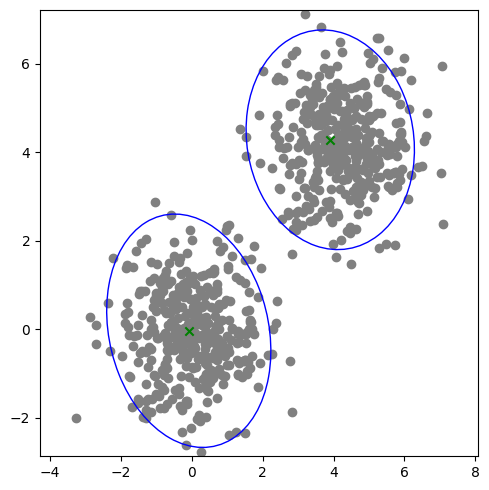

In [197]:
data = np.random.permutation(X)

xmin, ymin = np.min(data, axis=0)[0], np.min(data, axis=0)[1]
xmax, ymax = np.max(data, axis=0)[0], np.max(data, axis=0)[1]

result = GGMM(data, 2, np.eye(2)/100, 0.1, 30)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=data[:, 0], y=data[:, 1], color='grey', zorder = 1)
plot_GMM2(result, fig, ax)
#plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()